In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
import sys

# Lambda_idx = int(sys.argv[1])
# n_bins = int(sys.argv[2])
# ell_idx = int(sys.argv[3])


Lambda_idx = 18
n_bins = 10
ell_idx = 0

Lambda = Lambdas[Lambda_idx]

# CCAT-prime
zmin = 3.5
zmax = 8.1

oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
oup_fname +='zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_bins_%d_li_%d_mc_quad.npy'%(zmin, zmax, 
                                                                       Lambda_idx, 
                                                                       n_bins,
                                                                            ell_idx)
print(oup_fname)

/scratch/users/delon/LIMxCMBL/I_auto/comb_zmin_3.5_zmax_8.1_Lambda_idx_18_n_bins_10_li_0_mc_quad.npy


In [2]:
Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid


inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
from interpax import interp2d, interp1d
import jax.numpy as jnp

inner_dkparp_integral = jnp.array(inner_dkparp_integral.astype(np.float64))

2025-03-05 13:46:14.699736: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
import jax
import jax.numpy as jnp
_KI = np.array(KI)
@jax.jit
def f_KILo(chi, external_chi, Lambda):
    return (Lambda / jnp.pi 
            * jnp.interp(x = chi, xp = chis, 
                         fp = _KI, left = 0, right = 0) 
            * jnp.sinc(Lambda * (external_chi - chi) / np.pi))

In [5]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
eHIeHI_binned = np.zeros((n_bins,n_bins), dtype=np.float64)
dchi = np.mean(np.diff(chi_bin_edges))
print(dchi)

220.95378626532903


In [6]:
n_mc_points = 250 * 250

In [7]:
from jax import random

key = random.key(42)


In [8]:
from tqdm import trange

@jax.jit
def f_integrand(_chib,
                bin1_idx,
                bin2_idx,
                l1,
                r1,
                l2,
                r2,):
    
    key = random.key(bin1_idx+bin2_idx*11234+ell_idx*112345678)
    key1, key2 = random.split(key)
    external_chis = random.uniform(key1, shape=(n_mc_points,),
                                  minval = l1, maxval=r1)
    external_chips = random.uniform(key2, shape=(n_mc_points,),
                                  minval = l2, maxval=r2)
    
    #by construction chimin < exteranl_chis < chimax 
    #I Lo + Lo I
    _delta = jnp.abs(1 - external_chis/_chib) #p
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chis) 
            & (2*_chib - external_chis <= chimax)) #(p)
    
    cross_integrand = (2 * jnp.interp(x = external_chis, xp = chis, fp = _KI, left = 0, right = 0) 
                       * interp2d(xq = _chib, yq=jnp.log(_delta), 
                           x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral[ell_idx],
                           method='linear',) 
                       / (_chib**2))
    
    cross_integrand = jnp.where(_idx,
                               cross_integrand
                               * f_KILo(2*_chib - external_chis,
                                        external_chi = external_chips,
                                        Lambda=Lambda),
                                0)

    _delta = jnp.abs(1 - external_chips/_chib) #(n_ext)
    _delta = jnp.where(_delta < 1e-6, 1e-6, 
                     jnp.where(_delta > 0.7, 0.7, _delta))
    
    _idx = ((chimin <= 2*_chib - external_chips) 
            & (2*_chib - external_chips <= chimax)) #(n_ext)
    
    cross_integrand2 = (2 * jnp.interp(x = external_chips, xp = chis, fp = _KI, left = 0, right = 0) 
                       * interp2d(xq = _chib, yq=jnp.log(_delta), 
                           x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral[ell_idx],
                           method='linear',) 
                       / (_chib**2))
    
    cross_integrand2 = jnp.where(_idx,
                               cross_integrand2
                               * f_KILo(2*_chib - external_chips, 
                                        external_chi = external_chis, 
                                        Lambda=Lambda),
                                0)
    
    plus = _chib*(1+deltas)
    mins = _chib*(1-deltas)
    _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)
    
    LoLo_integrand  = jnp.where(_idxs,
                               f_KILo(plus, 
                                      external_chi = external_chis.reshape(-1,1), 
                                      Lambda=Lambda) 
                                * f_KILo(mins, 
                                         external_chi = external_chips.reshape(-1,1), 
                                         Lambda=Lambda),
                               0)
    LoLo_integrand += jnp.where(_idxs,
                               f_KILo(mins, 
                                      external_chi = external_chis.reshape(-1, 1), 
                                      Lambda=Lambda) 
                                * f_KILo(plus, 
                                         external_chi = external_chips.reshape(-1, 1), 
                                         Lambda=Lambda),0)
    LoLo_integrand *= (2 / _chib) #(p,d)
    LoLo_integrand = jnp.einsum('pd,d->pd', LoLo_integrand, deltas)
    LoLo_integrand = jnp.einsum('pd,d->pd', LoLo_integrand, 
                                interp1d(xq = _chib,
                                         x = chibs, f=inner_dkparp_integral[ell_idx],
                                         method='linear',))
    
    LoLo_integrand = jnp.trapezoid(x = jnp.log(deltas), y = LoLo_integrand, axis=-1)

    return LoLo_integrand - (cross_integrand + cross_integrand2)


In [9]:
oup = np.zeros((n_bins, n_bins))

In [10]:
from quadax import quadgk


In [11]:
for bin1_idx in range(n_bins):
    for bin2_idx in trange(bin1_idx, n_bins):
        l1, r1 = chi_bin_edges[bin1_idx], chi_bin_edges[bin1_idx + 1]
        l2, r2 = chi_bin_edges[bin2_idx], chi_bin_edges[bin2_idx + 1]

        res, _ = quadgk(f_integrand, jnp.hstack([10, jnp.linspace(chimin, chimax, 50), chimax_sample]),
                         epsabs = 0.0, epsrel = 1e-5, 
                        order = 61, max_ninter=10000,
                       args=(bin1_idx,bin2_idx,
                           l1,
                           r1,
                           l2,
                           r2,))
        oup[bin1_idx, bin2_idx] = oup[bin2_idx, bin1_idx] = jnp.mean(res)

100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


In [12]:
oup

array([[-1.45674130e-06, -1.31434021e-07,  2.61952579e-07,
        -5.34135651e-08,  8.60294413e-09,  4.34588721e-08,
        -3.94160828e-08,  1.36550549e-08,  1.58423159e-08,
        -2.63131597e-08],
       [-1.31434021e-07, -6.77838329e-07, -1.27536509e-07,
         1.42928769e-07, -3.35288641e-09, -2.14815650e-08,
         3.30122454e-08, -1.26676722e-08, -8.73507400e-09,
         1.91883434e-08],
       [ 2.61952579e-07, -1.27536509e-07, -3.36036635e-07,
        -7.65382637e-08,  6.80474272e-08,  9.97434935e-09,
        -1.93880094e-08,  1.71505192e-08, -6.16478368e-10,
        -1.11028697e-08],
       [-5.34135651e-08,  1.42928769e-07, -7.65382637e-08,
        -1.59366877e-07, -4.11224299e-08,  3.10336787e-08,
         9.63273994e-09, -1.27785933e-08,  8.29073432e-09,
         2.24134333e-09],
       [ 8.60294413e-09, -3.35288641e-09,  6.80474272e-08,
        -4.11224299e-08, -7.08535097e-08, -2.33813680e-08,
         1.43851802e-08,  7.49063656e-09, -9.13123266e-09,
         4.

In [13]:
np.save(oup_fname, oup)
print('outputted')

outputted


In [14]:

def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
#     print('external chi spacing', np.mean(np.diff(external_chis)))
    
    oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            oup[:,i,j] = (np.sum(base[:,
                                      idx1[0]:idx1[-1]+1,
                                      idx2[0]:idx2[-1]+1], 
                                 axis=(1, 2)) / len(idx1) / len(idx2))
    return oup

In [15]:
comb_n_external = 1500
comb_fname = '/scratch/users/delon/LIMxCMBL/I_auto/old/comb_'
comb_fname += 'zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_jax_quad.npy'%(zmin, zmax, 
                                                                         Lambda_idx, 
                                                                         comb_n_external,)

comb_unbinned = np.load(comb_fname)
comb = get_binned(comb_unbinned, n_external = comb_n_external)


In [19]:
import matplotlib.pyplot as plt

In [21]:
vb = np.max(np.abs(comb[ell_idx]))

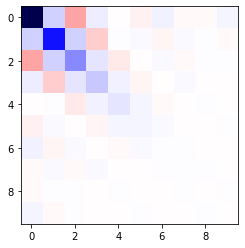

In [22]:
plt.imshow(comb[ell_idx],
          vmin = -vb,
          vmax = vb,
          cmap = 'seismic')

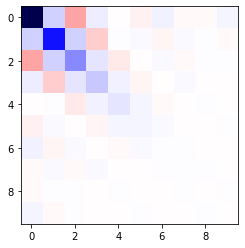

In [23]:
plt.imshow(oup,
          vmin = -vb,
          vmax = vb,
          cmap = 'seismic')

In [24]:
print((comb[ell_idx]-oup)/comb[ell_idx])

[[ 3.45940197e-03  2.20249583e-02  2.83082721e-04  4.96595415e-03
   8.15183248e-03  1.24848824e-03  6.92093970e-03  5.84566755e-03
  -4.32452123e-03  2.73684462e-03]
 [ 2.20249583e-02  1.49966695e-03 -6.62371353e-03  1.12808756e-03
   1.20481825e-01 -6.63773048e-03  9.81599521e-05  3.37601980e-02
  -2.14595034e-02 -3.64253386e-03]
 [ 2.83082721e-04 -6.62371353e-03 -1.40750721e-03 -1.49347206e-02
   2.63649171e-04 -2.53345982e-02 -2.90559689e-03 -7.06482768e-04
   2.11567879e-01 -1.86161304e-02]
 [ 4.96595415e-03  1.12808756e-03 -1.49347206e-02 -3.85601331e-03
  -9.60631478e-03 -2.91002881e-03 -2.59217747e-02 -4.46206848e-03
   2.12287574e-03 -4.27942273e-02]
 [ 8.15183248e-03  1.20481825e-01  2.63649171e-04 -9.60631478e-03
  -4.09021666e-03  3.18961706e-03  1.13440767e-03 -1.35225361e-02
  -6.23576244e-03  9.12956692e-03]
 [ 1.24848824e-03 -6.63773048e-03 -2.53345982e-02 -2.91002881e-03
   3.18961706e-03 -3.82515647e-03 -6.10969510e-03 -1.20308183e-03
  -6.77446968e-03  4.39161478e-04

In [26]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 101)

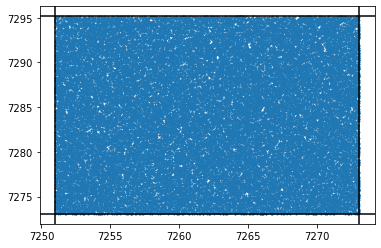

In [32]:
bin1_idx =13
bin2_idx =14
l1=chi_bin_edges[13]
l2=r1=chi_bin_edges[14]
r2=chi_bin_edges[15]

key = random.key(bin1_idx+bin2_idx*11234+ell_idx*112345678)
key1, key2 = random.split(key)
external_chis = random.uniform(key1, shape=(n_mc_points,),
                              minval = l1, maxval=r1)
external_chips = random.uniform(key2, shape=(n_mc_points,),
                              minval = l2, maxval=r2)
plt.axvline(l1, c='k')
plt.axvline(r1, c='k')
plt.axhline(l2, c='k')
plt.axhline(r2, c='k')

plt.scatter(x = external_chis, y = external_chips,s =1)